# Mounting your Google Drive files in Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/projects/nlp/sentiment_analysis/

/content/drive/My Drive/projects/nlp/sentiment_analysis


# **Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import csv
import re
import gc
import matplotlib.pyplot as plt
from tabulate import tabulate

from string import punctuation
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import Activation, GlobalMaxPool1D, Dropout
from keras.layers import SpatialDropout1D, Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils.np_utils import to_categorical

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# **Preprocessing steps**

In [ ]:
# Read data
data = []
with open('sentipers_sentiment.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader: # each row is a list
        data.append(row)
data.pop(0)
data = np.array(data)

# Convert labels to one-hot vectors
target = []
for i in range(data.shape[0]):
  if data[i][0] == 'Positive':
    target.append([1,0,0])
  if data[i][0] == 'Neutral':
    target.append([0,1,0])
  if data[i][0] == 'Negative':
    target.append([0,0,1])

#Split data to train and test
split_point = round(80*data.shape[0]/100)
data_train = data[:split_point]
data_test = data[split_point:]
target_train = target[:split_point]
target_test = target[split_point:]

x_train,x_test,y_train,y_test = [],[],[],[]

for i in range(data_train.shape[0]):
  y_train.append(target_train[i])
  x_train.append(data_train[i][1])

for i in range(data_test.shape[0]):
  y_test.append(target_test[i])
  x_test.append(data_test[i][1])

In [ ]:
max_features = 70000
tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(list(x_train))
encoded_docs_train = tokenizer.texts_to_sequences(x_train)

tokenizer.fit_on_texts(list(x_test))
encoded_docs_test = tokenizer.texts_to_sequences(x_test)

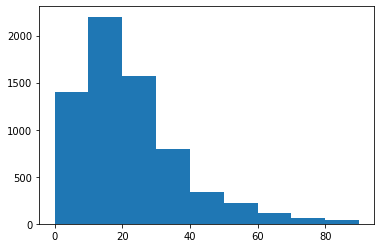

In [ ]:
# How do you know what is the best "maxlen" to set?
# Drow length of sentences plot for determine max_length value
totalNumWords = [len(one_comment) for one_comment in encoded_docs_train]
plt.hist(totalNumWords,bins = np.arange(0,100,10))
plt.show()

In [ ]:
# maxlen determine the size of backpropagation
max_length = 80
# Use pad_sequences for equalize the size of the sequences

Xtrain = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
ytrain = np.array(y_train)

Xtest = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')
ytest = np.array(y_test)

# **Functions**

In [ ]:
def loadEmbeddingMatrix(typeToLoad):

    if(typeToLoad=="glove"):
        EMBEDDING_FILE='vectors.txt'
        embed_size = 300
        embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
        with open(EMBEDDING_FILE,'r', encoding='utf8')as f:
            for line in f:
                try:
                    values = line.split()
                    if len(values)==301:
                        word = values[0]
                        coefs = np.asarray(values[1:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==302:
                        word = values[0]+'\u200c'+values[1]
                        coefs = np.asarray(values[2:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==303:
                        word = values[0]+'\u200c'+values[1]+'\u200c'+values[2]
                        coefs = np.asarray(values[3:], dtype='float32')
                        embeddings_index[word] = coefs
                except Exception as inst:
                        print(inst)

    gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the
        #same statistics for the rest of our own random generated weights.
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1, embed_size))
    gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both
        #our own dictionary and loaded pretrained embedding.
    embeddedCount = 0
    for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')

    del(embeddings_index)
    gc.collect()

        #finally, return the embedding matrix
    return embedding_matrix

# **Build and train models**

- LSTM with pretrained model
- RNN with pretrained model
- GRU with pretrained model
- LSTM without pretrained model
- RNN without pretrained model
- GRU without pretrained model

##building Bidirectional LSTM model with GloVe pretrain

In [ ]:
# Embedding layer is the first layer of our NN
embedding_matrix = loadEmbeddingMatrix('glove')

inp = Input(shape=(max_length, ))
# trainable means, our embedding matrix become finetune or not
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=True)(inp)
# Each layer of RNNs can be a bidirectional layer
# Dropout avoiding from overfiting
x = Bidirectional(LSTM(80, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = keras.Model(inputs=inp, outputs=x)
print(model.summary())
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 256
epochs = 5
# fit network
hist1 = model.fit(Xtrain, ytrain, batch_size=batch_size, epochs=epochs, validation_split=0.2)
# evaluate
loss1, acc1 = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc1*100))

total embedded: 5554 common words
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 80)]              0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 80, 300)           3825300   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 80, 160)           243840    
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 160)               0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 50)                8050      
_________________________________________________________________
dropout_33 (Dropout)    

##building Bidirectional simple RNN model with GloVe pretrain

In [ ]:
embedding_matrix = loadEmbeddingMatrix('glove')

inp = Input(shape=(max_length, ))
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=True)(inp)
x = Bidirectional(SimpleRNN(80, return_sequences=True,name='RNN_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = keras.Model(inputs=inp, outputs=x)
print(model.summary())
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 256
epochs = 5
# fit network
hist2 = model.fit(Xtrain, ytrain, batch_size=batch_size, epochs=epochs, validation_split=0.2)
# evaluate
loss2, acc2 = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc2*100))

total embedded: 5554 common words
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 80)]              0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 80, 300)           3825300   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 80, 160)           60960     
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 160)               0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 50)                8050      
_________________________________________________________________
dropout_35 (Dropout)    

##building Bidirectional GRU model with GloVe pretrain

In [ ]:
embedding_matrix = loadEmbeddingMatrix('glove')

inp = Input(shape=(max_length, ))
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=True)(inp)
x = Bidirectional(GRU(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = keras.Model(inputs=inp, outputs=x)
print(model.summary())
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 256
epochs = 5
# fit network
hist3 = model.fit(Xtrain, ytrain, batch_size=batch_size, epochs=epochs, validation_split=0.2)
# evaluate
loss3, acc3 = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc3*100))

total embedded: 5554 common words
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 80)]              0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 80, 300)           3825300   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 80, 120)           130320    
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 120)               0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_37 (Dropout)    

##building Bidirectional LSTM model with out pretrain

In [ ]:
inp = Input(shape=(max_length, ))
embed_size = 300
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(LSTM(80, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = keras.Model(inputs=inp, outputs=x)
print(model.summary())
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
hist4 = model.fit(Xtrain, ytrain, epochs=5, validation_split=0.2, verbose=1)
# evaluate
loss4, acc4 = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc5*100))

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 80)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 80, 300)           21000000  
_________________________________________________________________
bidirectional_9 (Bidirection (None, 80, 120)           173280    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 120)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_19 (Dropout)         (None, 50)                0   

##building Bidirectional Simple RNN model with out pretrain

In [ ]:
inp = Input(shape=(max_length, ))
embed_size = 300
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(SimpleRNN(80, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = keras.Model(inputs=inp, outputs=x)
print(model.summary())
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
hist5 = model.fit(Xtrain, ytrain, epochs=5, validation_split=0.2, verbose=1)
# evaluate
loss5, acc5 = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc6*100))

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 80)]              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 80, 300)           21000000  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 80, 120)           43320     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 120)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0  

##building Bidirectional GRU model with out pretrain

In [ ]:
inp = Input(shape=(max_length, ))
embed_size = 300
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(SimpleRNN(80, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = keras.Model(inputs=inp, outputs=x)
print(model.summary())
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
hist6 = model.fit(Xtrain, ytrain, epochs=5, validation_split=0.2, verbose=1)
# evaluate
loss6, acc6 = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc7*100))

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 80)]              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 80, 300)           21000000  
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 80, 120)           43320     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 120)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_23 (Dropout)         (None, 50)                0  

# **Accuracy/Loss plots**

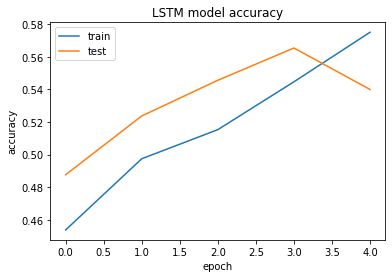

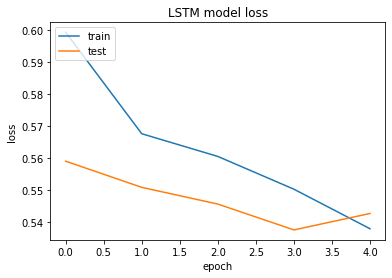

In [ ]:
# summarize history for accuracy
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

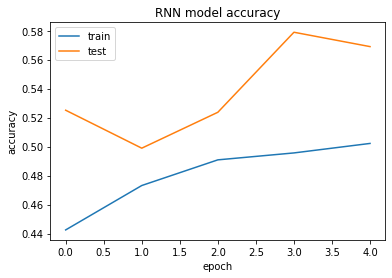

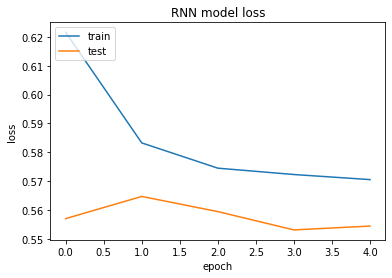

In [ ]:
# summarize history for accuracy
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('RNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('RNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

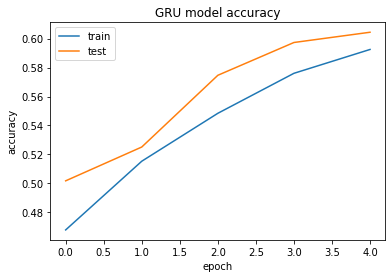

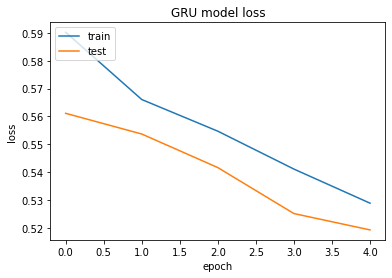

In [ ]:
# summarize history for accuracy
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('GRU model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('GRU model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

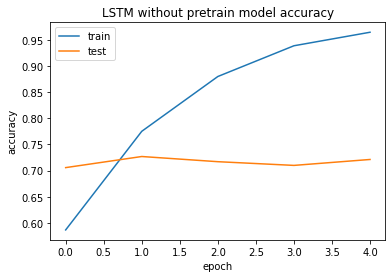

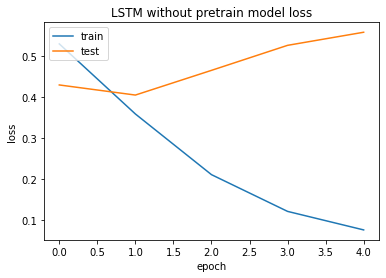

In [ ]:
# summarize history for accuracy
plt.plot(hist4.history['accuracy'])
plt.plot(hist4.history['val_accuracy'])
plt.title('LSTM without pretrain model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('LSTM without pretrain model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

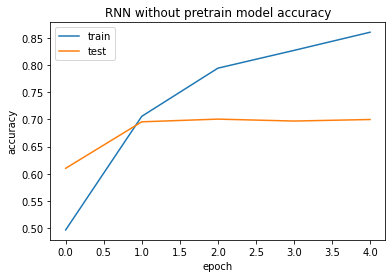

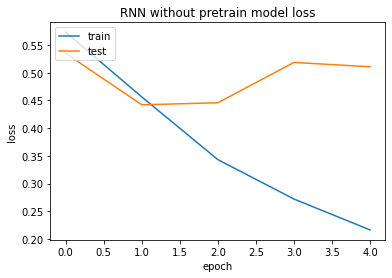

In [ ]:
# summarize history for accuracy
plt.plot(hist5.history['accuracy'])
plt.plot(hist5.history['val_accuracy'])
plt.title('RNN without pretrain model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist5.history['loss'])
plt.plot(hist5.history['val_loss'])
plt.title('RNN without pretrain model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

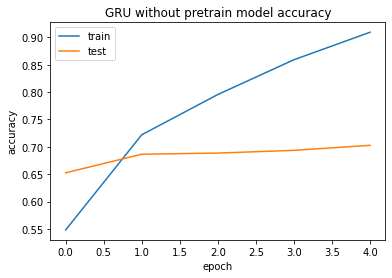

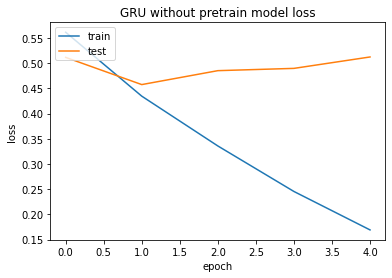

In [ ]:
# summarize history for accuracy
plt.plot(hist6.history['accuracy'])
plt.plot(hist6.history['val_accuracy'])
plt.title('GRU without pretrain model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist6.history['loss'])
plt.plot(hist6.history['val_loss'])
plt.title('GRU without pretrain model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

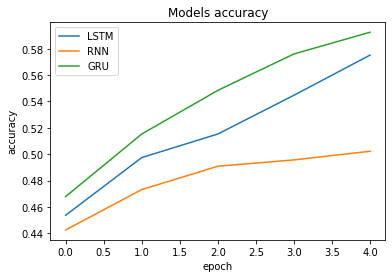

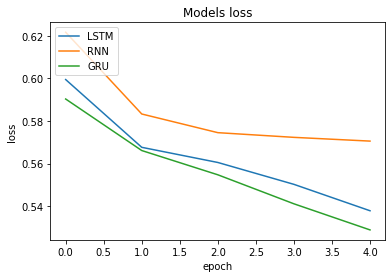

In [ ]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist2.history['accuracy'])
plt.plot(hist3.history['accuracy'])


plt.title('Models accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LSTM', 'RNN', 'GRU'], loc='upper left')
plt.show()

plt.plot(hist1.history['loss'])
plt.plot(hist2.history['loss'])
plt.plot(hist3.history['loss'])


plt.title('Models loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LSTM', 'RNN', 'GRU'], loc='upper left')
plt.show()

# **Results of all models**

In [ ]:
list_model_name = ['LSTM','RNN','GRU', 'LSTM without pre', 'RNN without pre', 'GRU without pre']
loss_list = [hist1.history['loss'][4], hist2.history['loss'][4], hist3.history['loss'][4], np.squeeze(hist4.history['loss']), np.squeeze(hist5.history['loss']), np.squeeze(hist6.history['loss'])]
accuracy_list = [hist1.history['accuracy'][4], hist2.history['accuracy'][4], hist3.history['accuracy'][4], np.squeeze(hist4.history['accuracy']), np.squeeze(hist5.history['accuracy']), np.squeeze(hist6.history['accuracy'])]
vall_loss = [hist1.history['val_loss'][4], hist2.history['val_loss'][4], hist3.history['val_loss'][4], np.squeeze(hist4.history['val_loss']), np.squeeze(hist5.history['val_loss']), np.squeeze(hist6.history['val_loss'])]
vall_accuracy = [hist1.history['val_accuracy'][4], hist2.history['val_accuracy'][4], hist3.history['val_accuracy'][4], np.squeeze(hist4.history['val_accuracy']), np.squeeze(hist5.history['val_accuracy']), np.squeeze(hist6.history['val_accuracy'])]
test_loss = [loss1, loss2, loss3, loss4, loss5, loss6]
test_accuracy = [acc1, acc2, acc3, acc4, acc5, acc6]

a = np.array([list_model_name])
b = [loss_list]
c = [accuracy_list]
d = [vall_loss]
e = [vall_accuracy]
f = [test_loss]
g = [test_accuracy]

Matrix = np.concatenate((a, b, c, d, e, f, g))
Matrix = [[Matrix[j][i] for j in range(len(Matrix))] for i in range(len(Matrix[0]))]
print(tabulate(Matrix, headers=["Model", "loss", "accuracy","vall_loss","vall_accuracy", "test_loss", "test_accuracy"], tablefmt="grid"))

+------------------+----------+------------+-------------+-----------------+-------------+-----------------+
| Model            |     loss |   accuracy |   vall_loss |   vall_accuracy |   test_loss |   test_accuracy |
+==================+==========+============+=============+=================+=============+=================+
| LSTM             | 0.53781  |   0.575146 |    0.5426   |        0.539986 |    0.574341 |        0.494051 |
+------------------+----------+------------+-------------+-----------------+-------------+-----------------+
| RNN              | 0.570518 |   0.502213 |    0.5544   |        0.569002 |    0.569263 |        0.513314 |
+------------------+----------+------------+-------------+-----------------+-------------+-----------------+
| GRU              | 0.528814 |   0.592494 |    0.519198 |        0.604388 |    0.573348 |        0.524079 |
+------------------+----------+------------+-------------+-----------------+-------------+-----------------+
| LSTM without pre 